In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

# Path to the filtered CSV file
combine = '/content/gdrive/MyDrive/PhD_Data/combined/Combined_dataset_utk_fgnet_morph_allface.csv'

# Read the filtered CSV file into a DataFrame
combine = pd.read_csv(combine)

# Display the first few rows of the DataFrame to verify the contents
combine

filename  age  gender ethnicity
0          078A12_1.JPG   12       1         W
1          078A05_1.JPG    5       1         W
2          077A15_0.JPG   15       0         W
3          076A01_0.JPG    1       0         W
4          075A06_1.JPG    6       1         W
...                 ...  ...     ...       ...
12209  282278_04M20.JPG   20       1         B
12210  326393_02M19.JPG   19       1         W
12211  326759_03M18.JPG   18       1         W
12212  330586_03M16.JPG   16       1         W
12213  279966_01M20.JPG   20       1         B

[12214 rows x 4 columns]

In [ ]:
import pandas as pd
import os
import dlib
import cv2
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Path to the filtered CSV file
combine_path = '/content/gdrive/MyDrive/PhD_Data/combined/Combined_dataset_utk_fgnet_morph_allface.csv'

# Read the filtered CSV file into a DataFrame
combine_df = pd.read_csv(combine_path)

# Define paths
image_folder = '/content/gdrive/MyDrive/PhD_Data/combined/Combined_dataset/db_final_5000_viola'
features_output_path = '/content/gdrive/MyDrive/PhD_Data/combined/Ratio_features/ratio_features.csv'

# Path to the dlib pre-trained shape predictor model
shape_predictor_path = '/content/gdrive/MyDrive/PhD_Data/combined/global_features/shape_predictor_68_face_landmarks.dat'

# Initialize dlib's face detector (HOG-based) and the shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor_path)

# Function to detect landmarks using dlib
def detect_landmarks(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    if len(rects) > 0:
        shape = predictor(gray, rects[0])
        landmarks = np.array([[shape.part(i).x, shape.part(i).y] for i in range(68)])
        return landmarks
    else:
        return None

# Function to calculate distances between points
def euclidean_distance(pt1, pt2):
    return np.linalg.norm(pt1 - pt2)

# Function to calculate anthropometric features
def calculate_anthropometric_features(landmarks):
    features = {}

    # Interocular Distance / Face Width
    interocular_distance = euclidean_distance(landmarks[36], landmarks[45])
    face_width = euclidean_distance(landmarks[0], landmarks[16])
    features['Interocular_Distance/Face_Width'] = interocular_distance / face_width

    # Nose Width / Face Width
    nose_width = euclidean_distance(landmarks[31], landmarks[35])
    features['Nose_Width/Face_Width'] = nose_width / face_width

    # Mouth Width / Face Width
    mouth_width = euclidean_distance(landmarks[48], landmarks[54])
    features['Mouth_Width/Face_Width'] = mouth_width / face_width

    # Nose Length / Face Height
    nose_length = euclidean_distance(landmarks[27], landmarks[33])
    face_height = euclidean_distance(landmarks[8], landmarks[27])
    features['Nose_Length/Face_Height'] = nose_length / face_height

    # Eye Width / Interocular Distance
    eye_width_left = euclidean_distance(landmarks[36], landmarks[39])
    eye_width_right = euclidean_distance(landmarks[42], landmarks[45])
    features['Eye_Width_Left/Interocular_Distance'] = eye_width_left / interocular_distance
    features['Eye_Width_Right/Interocular_Distance'] = eye_width_right / interocular_distance

    # Chin Height / Face Height
    chin_height = euclidean_distance(landmarks[8], landmarks[57])
    features['Chin_Height/Face_Height'] = chin_height / face_height

    # Eye to Nose Distance
    eye_midpoint = (landmarks[36] + landmarks[45]) / 2
    eye_to_nose = euclidean_distance(eye_midpoint, landmarks[30])
    features['Eye_to_Nose'] = eye_to_nose

    # Eye to Lip Distance
    lip_midpoint = (landmarks[48] + landmarks[54]) / 2
    eye_to_lip = euclidean_distance(eye_midpoint, lip_midpoint)
    features['Eye_to_Lip'] = eye_to_lip

    # Eye to Chin Distance
    eye_to_chin = euclidean_distance(eye_midpoint, landmarks[8])
    features['Eye_to_Chin'] = eye_to_chin

    # Eye to Eyebrow Distance (midpoint of eyes to midpoint of eyebrows)
    eyebrow_midpoint = (landmarks[21] + landmarks[22]) / 2
    eye_to_eyebrow = euclidean_distance(eye_midpoint, eyebrow_midpoint)
    features['Eye_to_Eyebrow'] = eye_to_eyebrow

    # Face Height / Face Width
    features['Face_Height/Face_Width'] = face_height / face_width

    return features

# Debugging: Print the size of combine_df to ensure it's read correctly
print(f"Total images to process: {len(combine_df)}")

# Open the CSV file to write features
with open(features_output_path, 'a') as f:
    # Write header if the file is empty
    if os.stat(features_output_path).st_size == 0:
        header = ",".join([
            'Interocular_Distance/Face_Width',
            'Nose_Width/Face_Width',
            'Mouth_Width/Face_Width',
            'Nose_Length/Face_Height',
            'Eye_Width_Left/Interocular_Distance',
            'Eye_Width_Right/Interocular_Distance',
            'Chin_Height/Face_Height',
            'Eye_to_Nose',
            'Eye_to_Lip',
            'Eye_to_Chin',
            'Eye_to_Eyebrow',
            'Face_Height/Face_Width',
            'filename'
        ])
        f.write(header + "\n")

    for idx, row in combine_df.iterrows():
        img_path = os.path.join(image_folder, row['filename'])

        # Load the image
        img = cv2.imread(img_path)

        if img is not None:
            landmark = detect_landmarks(img)

            if landmark is not None:
                print(f"Processing image: {row['filename']}")  # Debug print

                # Calculate anthropometric features and save to CSV
                features = calculate_anthropometric_features(landmark)
                features_str = ",".join(map(str, features.values()))
                f.write(features_str + f",{row['filename']}\n")
                f.flush()  # Ensure data is written to the file

            else:
                print(f"No landmarks detected for: {row['filename']}")  # Debug print
        else:
            print(f"Image not loaded: {row['filename']}")  # Debug print


Streaming output truncated to the last 5000 lines.
Processing image: 314814_03F17.JPG
Processing image: 334098_01M16.JPG
Processing image: 340914_01M18.JPG
Processing image: 315314_03M19.JPG
Processing image: 274255_04M19.JPG
Processing image: 328956_02M16.JPG
Processing image: 319784_01M18.JPG
Processing image: 295812_01M18.JPG
Processing image: 327781_00F20.JPG
Processing image: 349689_01F20.JPG
Processing image: 315619_03M18.JPG
Processing image: 338453_03M17.JPG
Processing image: 332429_01M17.JPG
Processing image: 299759_01M19.JPG
Processing image: 297858_00M19.JPG
Processing image: 311147_01M17.JPG
Processing image: 257276_05M20.JPG
Processing image: 289084_00F19.JPG
Processing image: 338643_01M17.JPG
Processing image: 347897_01M19.JPG
Processing image: 331030_02M18.JPG
Processing image: 325647_01M16.JPG
Processing image: 325166_02M16.JPG
Processing image: 305601_00M17.JPG
Processing image: 313621_02M19.JPG
Processing image: 288075_07M19.JPG
Processing image: 325474_03M19.JPG
Proc

In [ ]:
import pandas as pd

# Path to the features CSV file
features_output_path = '/content/gdrive/MyDrive/PhD_Data/combined/Ratio_features/ratio_features.csv'

# Read the CSV file into a DataFrame
features_ratio = pd.read_csv(features_output_path)

# Display the first few rows of the DataFrame
features_ratio

0.6332762871838296  0.1859363201867724  0.36606784410376475  \
0                0.641262            0.208143             0.383796   
1                0.634588            0.191148             0.331554   
2                0.608850            0.185499             0.371710   
3                0.613722            0.179884             0.296280   
4                0.623017            0.168661             0.308386   
...                   ...                 ...                  ...   
11588            0.650120            0.200000             0.362715   
11589            0.656723            0.207084             0.374961   
11590            0.587449            0.174945             0.312652   
11591            0.573282            0.189988             0.357307   
11592            0.618230            0.191293             0.359635   

       0.4949557973810925  0.29475367829133897  0.2848870639263896  \
0                0.535242             0.303204            0.288821   
1                0.391532             0.283147            0.283147   
2                0.456346             0.296234            0.305256   
3                0.437516             0.302216            0.302216   
4                0.446224             0.317869            0.298595   
...                   ...                  ...                 ...   
11588            0.403496             0.289048            0.290961   
11589            0.449183             0.301260            0.292835   
11590            0.433273             0.298564            0.277350   
11591            0.474250             0.310087            0.295985   
11592            0.444672             0.274959            0.290717   

       0.1734348348526537  51.56064390598706  83.50598780925833  \
0                0.195550          59.552498          81.181895   
1                0.308398          22.276669          64.623912   
2                0.313755          37.619809          74.741220   
3                0.249969          36.000000          79.006329   
4                0.249308          38.059164          85.552615   
...                   ...                ...                ...   
11588            0.276049          15.628500          36.003472   
11589            0.277350          20.597330          41.018289   
11590            0.266630          17.507141          38.013156   
11591            0.212718          25.019992          40.697051   
11592            0.175301          18.172782          41.575233   

       124.62142672911429  14.221462653327892  0.7158533603045077  \
0              128.150302           15.890249            0.688007   
1              112.250835           30.004166            0.674319   
2              125.822295           30.907119            0.677280   
3              124.004032           28.517538            0.677293   
4              129.663025           25.005000            0.780593   
...                   ...                 ...                 ...   
11588           60.500000            8.558621            0.775101   
11589           62.475995           10.111874            0.755371   
11590           59.518905            6.519202            0.749870   
11591           62.289646            6.576473            0.726408   
11592           61.051208           11.543396            0.707776   

           078A12_1.JPG  
0          077A15_0.JPG  
1          076A01_0.JPG  
2          075A06_1.JPG  
3          075A02_1.JPG  
4          074A15_1.JPG  
...                 ...  
11588  325964_01F18.JPG  
11589  282278_04M20.JPG  
11590  326393_02M19.JPG  
11591  330586_03M16.JPG  
11592  279966_01M20.JPG  

[11593 rows x 13 columns]

In [ ]:
import pandas as pd

# Define the header
header = [
    'Interocular_Distance/Face_Width',
    'Nose_Width/Face_Width',
    'Mouth_Width/Face_Width',
    'Nose_Length/Face_Height',
    'Eye_Width_Left/Interocular_Distance',
    'Eye_Width_Right/Interocular_Distance',
    'Chin_Height/Face_Height',
    'Eye_to_Nose',
    'Eye_to_Lip',
    'Eye_to_Chin',
    'Eye_to_Eyebrow',
    'Face_Height/Face_Width',
    'filename'
]

# Assuming features_ratio is your DataFrame
features_ratio.columns = header

In [ ]:
features_ratio

Interocular_Distance/Face_Width  Nose_Width/Face_Width  \
0                             0.641262               0.208143   
1                             0.634588               0.191148   
2                             0.608850               0.185499   
3                             0.613722               0.179884   
4                             0.623017               0.168661   
...                                ...                    ...   
11588                         0.650120               0.200000   
11589                         0.656723               0.207084   
11590                         0.587449               0.174945   
11591                         0.573282               0.189988   
11592                         0.618230               0.191293   

       Mouth_Width/Face_Width  Nose_Length/Face_Height  \
0                    0.383796                 0.535242   
1                    0.331554                 0.391532   
2                    0.371710                 0.456346   
3                    0.296280                 0.437516   
4                    0.308386                 0.446224   
...                       ...                      ...   
11588                0.362715                 0.403496   
11589                0.374961                 0.449183   
11590                0.312652                 0.433273   
11591                0.357307                 0.474250   
11592                0.359635                 0.444672   

       Eye_Width_Left/Interocular_Distance  \
0                                 0.303204   
1                                 0.283147   
2                                 0.296234   
3                                 0.302216   
4                                 0.317869   
...                                    ...   
11588                             0.289048   
11589                             0.301260   
11590                             0.298564   
11591                             0.310087   
11592                             0.274959   

       Eye_Width_Right/Interocular_Distance  Chin_Height/Face_Height  \
0                                  0.288821                 0.195550   
1                                  0.283147                 0.308398   
2                                  0.305256                 0.313755   
3                                  0.302216                 0.249969   
4                                  0.298595                 0.249308   
...                                     ...                      ...   
11588                              0.290961                 0.276049   
11589                              0.292835                 0.277350   
11590                              0.277350                 0.266630   
11591                              0.295985                 0.212718   
11592                              0.290717                 0.175301   

       Eye_to_Nose  Eye_to_Lip  Eye_to_Chin  Eye_to_Eyebrow  \
0        59.552498   81.181895   128.150302       15.890249   
1        22.276669   64.623912   112.250835       30.004166   
2        37.619809   74.741220   125.822295       30.907119   
3        36.000000   79.006329   124.004032       28.517538   
4        38.059164   85.552615   129.663025       25.005000   
...            ...         ...          ...             ...   
11588    15.628500   36.003472    60.500000        8.558621   
11589    20.597330   41.018289    62.475995       10.111874   
11590    17.507141   38.013156    59.518905        6.519202   
11591    25.019992   40.697051    62.289646        6.576473   
11592    18.172782   41.575233    61.051208       11.543396   

       Face_Height/Face_Width          filename  
0                    0.688007      077A15_0.JPG  
1                    0.674319      076A01_0.JPG  
2                    0.677280      075A06_1.JPG  
3                    0.677293      075A02_1.JPG  
4                    0.780593      074A15_1.JPG  
...                       ...               ...  
1158

In [ ]:
import pandas as pd

# Assuming combine and features_ratio DataFrames are already loaded
# combine contains columns ['filename', 'age']
# features_ratio contains the feature columns and 'filename'

# Merge the DataFrames based on the 'filename' column
merged_df = features_ratio.merge(combine[['filename', 'age']], on='filename', how='left')

# Display the merged DataFrame to verify
print(merged_df)


       Interocular_Distance/Face_Width  Nose_Width/Face_Width  \
0                             0.641262               0.208143   
1                             0.634588               0.191148   
2                             0.608850               0.185499   
3                             0.613722               0.179884   
4                             0.623017               0.168661   
...                                ...                    ...   
14944                         0.650120               0.200000   
14945                         0.656723               0.207084   
14946                         0.587449               0.174945   
14947                         0.573282               0.189988   
14948                         0.618230               0.191293   

       Mouth_Width/Face_Width  Nose_Length/Face_Height  \
0                    0.383796                 0.535242   
1                    0.331554                 0.391532   
2                    0.371710                

In [ ]:
# Set a threshold: if age < 18, set age_binary to 1, else 0
merged_df['age_binary'] = merged_df['age'].apply(lambda x: 1 if x < 18 else 0)

# Display the merged DataFrame to verify
print(merged_df)

       Interocular_Distance/Face_Width  Nose_Width/Face_Width  \
0                             0.641262               0.208143   
1                             0.634588               0.191148   
2                             0.608850               0.185499   
3                             0.613722               0.179884   
4                             0.623017               0.168661   
...                                ...                    ...   
14944                         0.650120               0.200000   
14945                         0.656723               0.207084   
14946                         0.587449               0.174945   
14947                         0.573282               0.189988   
14948                         0.618230               0.191293   

       Mouth_Width/Face_Width  Nose_Length/Face_Height  \
0                    0.383796                 0.535242   
1                    0.331554                 0.391532   
2                    0.371710                

In [ ]:
# Remove duplicates based on the 'filename' column
merged_df = merged_df.drop_duplicates(subset='filename')

In [ ]:
merged_df

Interocular_Distance/Face_Width  Nose_Width/Face_Width  \
0                             0.641262               0.208143   
1                             0.634588               0.191148   
2                             0.608850               0.185499   
3                             0.613722               0.179884   
4                             0.623017               0.168661   
...                                ...                    ...   
14944                         0.650120               0.200000   
14945                         0.656723               0.207084   
14946                         0.587449               0.174945   
14947                         0.573282               0.189988   
14948                         0.618230               0.191293   

       Mouth_Width/Face_Width  Nose_Length/Face_Height  \
0                    0.383796                 0.535242   
1                    0.331554                 0.391532   
2                    0.371710                 0.456346   
3                    0.296280                 0.437516   
4                    0.308386                 0.446224   
...                       ...                      ...   
14944                0.362715                 0.403496   
14945                0.374961                 0.449183   
14946                0.312652                 0.433273   
14947                0.357307                 0.474250   
14948                0.359635                 0.444672   

       Eye_Width_Left/Interocular_Distance  \
0                                 0.303204   
1                                 0.283147   
2                                 0.296234   
3                                 0.302216   
4                                 0.317869   
...                                    ...   
14944                             0.289048   
14945                             0.301260   
14946                             0.298564   
14947                             0.310087   
14948                             0.274959   

       Eye_Width_Right/Interocular_Distance  Chin_Height/Face_Height  \
0                                  0.288821                 0.195550   
1                                  0.283147                 0.308398   
2                                  0.305256                 0.313755   
3                                  0.302216                 0.249969   
4                                  0.298595                 0.249308   
...                                     ...                      ...   
14944                              0.290961                 0.276049   
14945                              0.292835                 0.277350   
14946                              0.277350                 0.266630   
14947                              0.295985                 0.212718   
14948                              0.290717                 0.175301   

       Eye_to_Nose  Eye_to_Lip  Eye_to_Chin  Eye_to_Eyebrow  \
0        59.552498   81.181895   128.150302       15.890249   
1        22.276669   64.623912   112.250835       30.004166   
2        37.619809   74.741220   125.822295       30.907119   
3        36.000000   79.006329   124.004032       28.517538   
4        38.059164   85.552615   129.663025       25.005000   
...            ...         ...          ...             ...   
14944    15.628500   36.003472    60.500000        8.558621   
14945    20.597330   41.018289    62.475995       10.111874   
14946    17.507141   38.013156    59.518905        6.519202   
14947    25.019992   40.697051    62.289646        6.576473   
14948    18.172782   41.575233    61.051208       11.543396   

       Face_Height/Face_Width          filename  age  age_binary  
0                    0.688007      077A15_0.JPG   15           1  
1                    0.674319      076A01_0.JPG    1           1  
2                    0.677280      075A06_1.JPG    6           1  
3                    0.677293      075A02_1.JPG    2           1  
4                  

In [ ]:
# Save the merged DataFrame to a CSV file
merged_output_path = '/content/gdrive/MyDrive/PhD_Data/combined/Ratio_features/mereged_anthropometric_final_features.csv'
merged_df.to_csv(merged_output_path, index=False)

In [ ]:
merged_df

Interocular_Distance/Face_Width  Nose_Width/Face_Width  \
0                             0.641262               0.208143   
1                             0.634588               0.191148   
2                             0.608850               0.185499   
3                             0.613722               0.179884   
4                             0.623017               0.168661   
...                                ...                    ...   
14944                         0.650120               0.200000   
14945                         0.656723               0.207084   
14946                         0.587449               0.174945   
14947                         0.573282               0.189988   
14948                         0.618230               0.191293   

       Mouth_Width/Face_Width  Nose_Length/Face_Height  \
0                    0.383796                 0.535242   
1                    0.331554                 0.391532   
2                    0.371710                 0.456346   
3                    0.296280                 0.437516   
4                    0.308386                 0.446224   
...                       ...                      ...   
14944                0.362715                 0.403496   
14945                0.374961                 0.449183   
14946                0.312652                 0.433273   
14947                0.357307                 0.474250   
14948                0.359635                 0.444672   

       Eye_Width_Left/Interocular_Distance  \
0                                 0.303204   
1                                 0.283147   
2                                 0.296234   
3                                 0.302216   
4                                 0.317869   
...                                    ...   
14944                             0.289048   
14945                             0.301260   
14946                             0.298564   
14947                             0.310087   
14948                             0.274959   

       Eye_Width_Right/Interocular_Distance  Chin_Height/Face_Height  \
0                                  0.288821                 0.195550   
1                                  0.283147                 0.308398   
2                                  0.305256                 0.313755   
3                                  0.302216                 0.249969   
4                                  0.298595                 0.249308   
...                                     ...                      ...   
14944                              0.290961                 0.276049   
14945                              0.292835                 0.277350   
14946                              0.277350                 0.266630   
14947                              0.295985                 0.212718   
14948                              0.290717                 0.175301   

       Eye_to_Nose  Eye_to_Lip  Eye_to_Chin  Eye_to_Eyebrow  \
0        59.552498   81.181895   128.150302       15.890249   
1        22.276669   64.623912   112.250835       30.004166   
2        37.619809   74.741220   125.822295       30.907119   
3        36.000000   79.006329   124.004032       28.517538   
4        38.059164   85.552615   129.663025       25.005000   
...            ...         ...          ...             ...   
14944    15.628500   36.003472    60.500000        8.558621   
14945    20.597330   41.018289    62.475995       10.111874   
14946    17.507141   38.013156    59.518905        6.519202   
14947    25.019992   40.697051    62.289646        6.576473   
14948    18.172782   41.575233    61.051208       11.543396   

       Face_Height/Face_Width          filename  age  age_binary  
0                    0.688007      077A15_0.JPG   15           1  
1                    0.674319      076A01_0.JPG    1           1  
2                    0.677280      075A06_1.JPG    6           1  
3                    0.677293      075A02_1.JPG    2           1  
4                  

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
# Prepare the data
X = merged_df.drop(columns=['filename', 'age_binary', 'age'])  # Features
y = merged_df['age_binary']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier (Random Forest in this case)
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.73
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.96      0.83      1448
           1       0.66      0.16      0.26       603

    accuracy                           0.73      2051
   macro avg       0.70      0.56      0.55      2051
weighted avg       0.71      0.73      0.67      2051



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

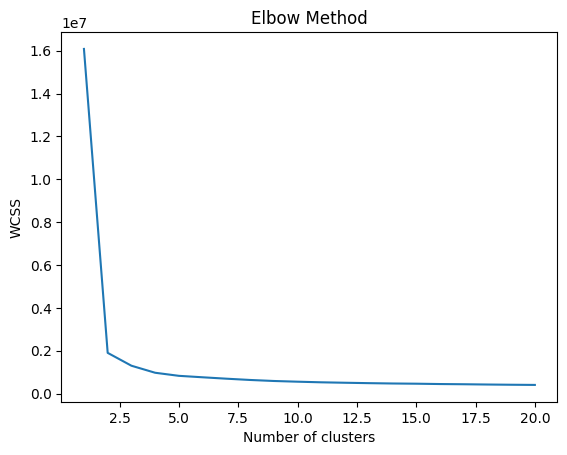

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

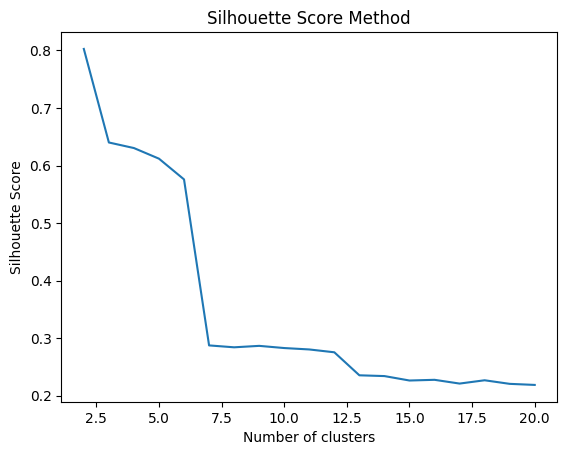

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


      Interocular_Distance/Face_Width  Nose_Width/Face_Width  \
0                            0.612807               0.219200   
1                            0.648449               0.216150   
2                            0.656600               0.230868   
3                            0.604096               0.207854   
4                            0.599891               0.184355   
...                               ...                    ...   
5607                         0.642554               0.244774   
5608                         0.618794               0.219280   
5609                         0.652802               0.264025   
5610                         0.617219               0.209813   
5611                         0.692258               0.248649   

      Mouth_Width/Face_Width  Nose_Length/Face_Height  \
0                   0.391782                 0.408773   
1                   0.375558                 0.450398   
2                   0.315924                 0.484139   
3  

<ipython-input-17-39d5e6a696f8>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class_0['cluster'] = kmeans.fit_predict(class_0.drop(columns=['age_binary', 'filename']))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
# Separate classes
class_0 = merged_df[merged_df['age_binary'] == 0]
class_1 = merged_df[merged_df['age_binary'] == 1]
n_class_1 = len(class_1)

# Elbow Method
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(class_0.drop(columns=['age_binary', 'filename']))
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Silhouette Score
silhouette_scores = []
for i in range(2, 21):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(class_0.drop(columns=['age_binary', 'filename']))
    score = silhouette_score(class_0.drop(columns=['age_binary', 'filename']), kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 21), silhouette_scores)
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Choose an optimal number of clusters based on the above methods
optimal_clusters = 10  # Example: based on elbow and silhouette methods

# Apply K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
class_0['cluster'] = kmeans.fit_predict(class_0.drop(columns=['age_binary', 'filename']))

# Sample from each cluster
sampled_class_0 = pd.DataFrame()
for cluster in range(optimal_clusters):
    cluster_data = class_0[class_0['cluster'] == cluster]
    if len(cluster_data) > n_class_1 / optimal_clusters:
        cluster_sample = cluster_data.sample(n=int(n_class_1 / optimal_clusters), random_state=42)
    else:
        cluster_sample = cluster_data
    sampled_class_0 = pd.concat([sampled_class_0, cluster_sample])

sampled_class_0 = sampled_class_0.drop(columns=['cluster'])
balanced_df = pd.concat([sampled_class_0, class_1])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the balanced DataFrame
print(balanced_df)

In [ ]:
balanced_df

Interocular_Distance/Face_Width  Nose_Width/Face_Width  \
0                            0.612807               0.219200   
1                            0.648449               0.216150   
2                            0.656600               0.230868   
3                            0.604096               0.207854   
4                            0.599891               0.184355   
...                               ...                    ...   
5607                         0.642554               0.244774   
5608                         0.618794               0.219280   
5609                         0.652802               0.264025   
5610                         0.617219               0.209813   
5611                         0.692258               0.248649   

      Mouth_Width/Face_Width  Nose_Length/Face_Height  \
0                   0.391782                 0.408773   
1                   0.375558                 0.450398   
2                   0.315924                 0.484139   
3                   0.370117                 0.487860   
4                   0.357369                 0.387742   
...                      ...                      ...   
5607                0.389563                 0.424040   
5608                0.408296                 0.359675   
5609                0.431077                 0.425631   
5610                0.345574                 0.444221   
5611                0.362239                 0.562326   

      Eye_Width_Left/Interocular_Distance  \
0                                0.274856   
1                                0.293179   
2                                0.280044   
3                                0.290967   
4                                0.288413   
...                                   ...   
5607                             0.328798   
5608                             0.299933   
5609                             0.276346   
5610                             0.302594   
5611                             0.281469   

      Eye_Width_Right/Interocular_Distance  Chin_Height/Face_Height  \
0                                 0.278800                 0.280011   
1                                 0.289581                 0.261160   
2                                 0.278204                 0.236334   
3                                 0.291957                 0.265856   
4                                 0.291544                 0.287681   
...                                    ...                      ...   
5607                              0.272052                 0.240743   
5608                              0.272019                 0.343861   
5609                              0.298361                 0.199007   
5610                              0.302594                 0.224365   
5611                              0.281144                 0.223111   

      Eye_to_Nose  Eye_to_Lip  Eye_to_Chin  Eye_to_Eyebrow  \
0       13.583078   36.090165    58.638724       12.589678   
1       18.607794   38.147739    61.491869       12.369317   
2       22.000000   45.011110    63.031738       10.547512   
3       46.524187   78.000000   122.525508       25.578311   
4        9.552487   36.667424    59.188259       14.713939   
...           ...         ...          ...             ...   
5607    21.523243   42.240384    66.017043        8.139410   
5608     5.852350   33.305405    56.224994       15.402922   
5609    17.066048   38.013156    59.052942       11.672618   
5610    19.500000   41.500000    63.531488        7.017834   
5611    53.500000  107.510465   136.532963       34.000000   

      Face_Height/Face_Width                               filename  age  \
0                   0.798695                       323767_02F17.JPG   17   
1                   0.838512                       344761_00M16.JPG   16   
2                   0.778039                       276472_04M20.JPG   20   
3                   0.811768                           11830A47.jpg   47   
4                   0.742457     

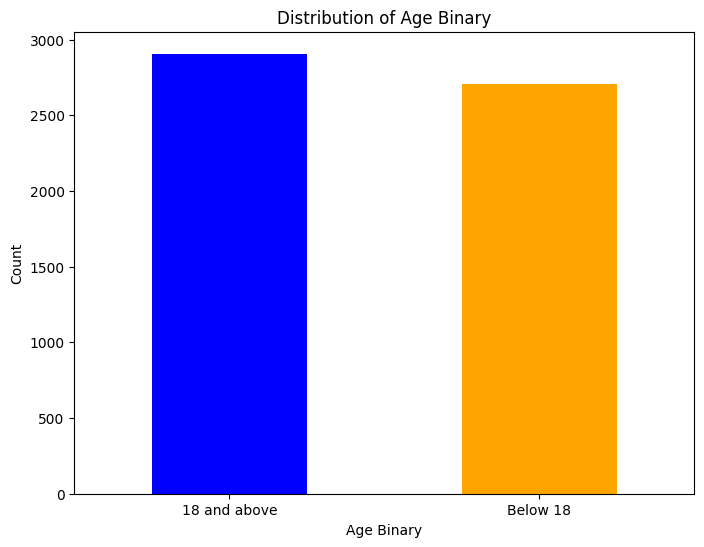

In [ ]:
# Plot the distribution of age_binary
plt.figure(figsize=(8, 6))
balanced_df['age_binary'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Age Binary')
plt.xlabel('Age Binary')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['18 and above', 'Below 18'], rotation=0)
plt.show()

In [ ]:
# Save the merged DataFrame to a CSV file
merged_output_path = '/content/gdrive/MyDrive/PhD_Data/combined/Ratio_features/balanced_ratio_features.csv'
balanced_df.to_csv(merged_output_path, index=False)

In [ ]:
import pandas as pd

# Path to the filtered CSV file
combine = '/content/gdrive/MyDrive/PhD_Data/combined/Ratio_features/balanced_ratio_features.csv'

# Read the filtered CSV file into a DataFrame
balanced_df = pd.read_csv(combine)

# Display the first few rows of the DataFrame to verify the contents
balanced_df

Interocular_Distance/Face_Width  Nose_Width/Face_Width  \
0                            0.612807               0.219200   
1                            0.648449               0.216150   
2                            0.656600               0.230868   
3                            0.604096               0.207854   
4                            0.599891               0.184355   
...                               ...                    ...   
5607                         0.642554               0.244774   
5608                         0.618794               0.219280   
5609                         0.652802               0.264025   
5610                         0.617219               0.209813   
5611                         0.692258               0.248649   

      Mouth_Width/Face_Width  Nose_Length/Face_Height  \
0                   0.391782                 0.408773   
1                   0.375558                 0.450398   
2                   0.315924                 0.484139   
3                   0.370117                 0.487860   
4                   0.357369                 0.387742   
...                      ...                      ...   
5607                0.389563                 0.424040   
5608                0.408296                 0.359675   
5609                0.431077                 0.425631   
5610                0.345574                 0.444221   
5611                0.362239                 0.562326   

      Eye_Width_Left/Interocular_Distance  \
0                                0.274856   
1                                0.293179   
2                                0.280044   
3                                0.290967   
4                                0.288413   
...                                   ...   
5607                             0.328798   
5608                             0.299933   
5609                             0.276346   
5610                             0.302594   
5611                             0.281469   

      Eye_Width_Right/Interocular_Distance  Chin_Height/Face_Height  \
0                                 0.278800                 0.280011   
1                                 0.289581                 0.261160   
2                                 0.278204                 0.236334   
3                                 0.291957                 0.265856   
4                                 0.291544                 0.287681   
...                                    ...                      ...   
5607                              0.272052                 0.240743   
5608                              0.272019                 0.343861   
5609                              0.298361                 0.199007   
5610                              0.302594                 0.224365   
5611                              0.281144                 0.223111   

      Eye_to_Nose  Eye_to_Lip  Eye_to_Chin  Eye_to_Eyebrow  \
0       13.583078   36.090165    58.638724       12.589678   
1       18.607794   38.147739    61.491869       12.369317   
2       22.000000   45.011110    63.031738       10.547512   
3       46.524187   78.000000   122.525508       25.578311   
4        9.552487   36.667424    59.188259       14.713939   
...           ...         ...          ...             ...   
5607    21.523243   42.240384    66.017043        8.139410   
5608     5.852350   33.305405    56.224994       15.402922   
5609    17.066048   38.013156    59.052942       11.672618   
5610    19.500000   41.500000    63.531488        7.017834   
5611    53.500000  107.510465   136.532963       34.000000   

      Face_Height/Face_Width                               filename  age  \
0                   0.798695                       323767_02F17.JPG   17   
1                   0.838512                       344761_00M16.JPG   16   
2                   0.778039                       276472_04M20.JPG   20   
3                   0.811768                           11830A47.jpg   47   
4                   0.742457     

In [ ]:
import pandas as pd

# Path to the filtered CSV file
combine = '/content/gdrive/MyDrive/PhD_Data/combined/Ratio_features/balanced_ratio_features.csv'

# Read the filtered CSV file into a DataFrame
balanced_df = pd.read_csv(combine)

# Display the first few rows of the DataFrame to verify the contents
balanced_df

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
# Prepare the data
X = balanced_df.drop(columns=['filename', 'age_binary', 'age'])  # Features
y = balanced_df['age_binary']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier (Random Forest in this case)
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.76      0.80       579
           1       0.77      0.85      0.81       544

    accuracy                           0.80      1123
   macro avg       0.81      0.80      0.80      1123
weighted avg       0.81      0.80      0.80      1123



Chi-square

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from google.colab import drive
# Prepare to store Chi-Square results
chi2_results = []
p_values = []
features = []

# Perform Chi-Square test for each feature across age_binary groups
for i in range(balanced_df.shape[1] - 2):  # Exclude 'filename' and 'age_binary' columns
    feature_column = balanced_df.columns[i]
    contingency_table = pd.crosstab(balanced_df['age_binary'], balanced_df[feature_column])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi2_results.append(chi2)
    p_values.append(p)
    features.append(feature_column)

# Create a DataFrame for Chi-Square results
results_df_chi = pd.DataFrame({
    'Feature': features,
    'Chi2': chi2_results,
    'p-value': p_values
})

# Display the results
from IPython.display import display
display(results_df_chi)

print(results_df_chi)

Feature         Chi2       p-value
0        Interocular_Distance/Face_Width  5270.860587  1.421977e-01
1                  Nose_Width/Face_Width  4979.647397  4.785948e-03
2                 Mouth_Width/Face_Width  5234.329742  8.163201e-02
3                Nose_Length/Face_Height  4641.150836  9.210637e-04
4    Eye_Width_Left/Interocular_Distance  4122.233099  3.562150e-07
5   Eye_Width_Right/Interocular_Distance  4211.451976  1.955675e-08
6                Chin_Height/Face_Height  4865.499508  1.338586e-03
7                            Eye_to_Nose  2806.687225  4.011113e-45
8                             Eye_to_Lip  2540.126836  6.347187e-57
9                            Eye_to_Chin  2810.838167  1.173062e-42
10                        Eye_to_Eyebrow  1794.123629  1.614843e-57
11                Face_Height/Face_Width  5281.705407  7.765829e-02
12                              filename  5612.000000  4.937239e-01

                                 Feature         Chi2       p-value
0        Interocular_Distance/Face_Width  5270.860587  1.421977e-01
1                  Nose_Width/Face_Width  4979.647397  4.785948e-03
2                 Mouth_Width/Face_Width  5234.329742  8.163201e-02
3                Nose_Length/Face_Height  4641.150836  9.210637e-04
4    Eye_Width_Left/Interocular_Distance  4122.233099  3.562150e-07
5   Eye_Width_Right/Interocular_Distance  4211.451976  1.955675e-08
6                Chin_Height/Face_Height  4865.499508  1.338586e-03
7                            Eye_to_Nose  2806.687225  4.011113e-45
8                             Eye_to_Lip  2540.126836  6.347187e-57
9                            Eye_to_Chin  2810.838167  1.173062e-42
10                        Eye_to_Eyebrow  1794.123629  1.614843e-57
11                Face_Height/Face_Width  5281.705407  7.765829e-02
12                              filename  5612.000000  4.937239e-01


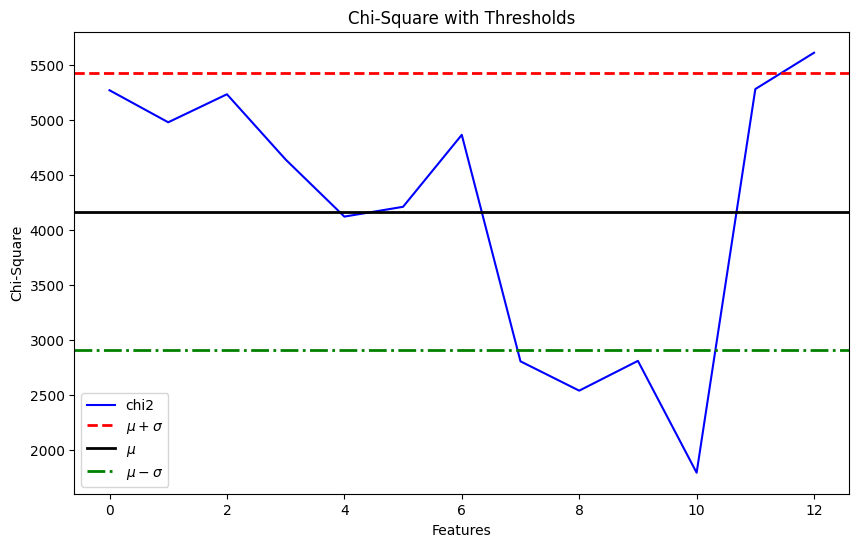

Eye_to_Nose  Eye_to_Lip  Eye_to_Chin  Eye_to_Eyebrow  \
0       13.583078   36.090165    58.638724       12.589678   
1       18.607794   38.147739    61.491869       12.369317   
2       22.000000   45.011110    63.031738       10.547512   
3       46.524187   78.000000   122.525508       25.578311   
4        9.552487   36.667424    59.188259       14.713939   
...           ...         ...          ...             ...   
5607    21.523243   42.240384    66.017043        8.139410   
5608     5.852350   33.305405    56.224994       15.402922   
5609    17.066048   38.013156    59.052942       11.672618   
5610    19.500000   41.500000    63.531488        7.017834   
5611    53.500000  107.510465   136.532963       34.000000   

                                   filename  age_binary  
0                          323767_02F17.JPG           1  
1                          344761_00M16.JPG           1  
2                          276472_04M20.JPG           0  
3                              11830A47.jpg           0  
4                          312275_00M17.JPG           1  
...                                     ...         ...  
5607                       337818_02F16.JPG           1  
5608                       336925_00M16.JPG           1  
5609                       312798_00M16.JPG           1  
5610                       319749_02M17.JPG           1  
5611  80_0_0_20170111205531200.jpg.chip.jpg           0  

[5612 rows x 6 columns]

In [ ]:
# Calculate mean and standard deviation of Chi-Square values
mean_chi2 = results_df_chi['Chi2'].mean()
std_chi2 = results_df_chi['Chi2'].std()

# Define thresholds
threshold1 = mean_chi2 + std_chi2
threshold2 = mean_chi2
threshold3 = mean_chi2 - std_chi2

# Plot the scores
plt.figure(figsize=(10, 6))
plt.plot(results_df_chi['Chi2'].values, label='chi2', color='blue')

# Add threshold lines
plt.axhline(y=threshold1, color='red', linestyle='--', linewidth=2, label='$\mu + \sigma$')
plt.axhline(y=threshold2, color='black', linestyle='-', linewidth=2, label='$\mu$')
plt.axhline(y=threshold3, color='green', linestyle='-.', linewidth=2, label='$\mu - \sigma$')

# Add labels and legend
plt.xlabel('Features')
plt.ylabel('Chi-Square')
plt.title('Chi-Square with Thresholds')
plt.legend()

# Show the plot
plt.show()

# Filter features based on thresholds
filtered_features = results_df_chi[(results_df_chi['Chi2'] > threshold1) | (results_df_chi['Chi2'] < threshold3)]['Feature']

# Create a new DataFrame with only the filtered features
filtered_feature_columns = filtered_features.tolist() + ['age_binary']
filtered_df = balanced_df[filtered_feature_columns]

# Display the filtered DataFrame
display(filtered_df)

In [ ]:
filtered_df

Eye_to_Nose  Eye_to_Lip  Eye_to_Chin  Eye_to_Eyebrow  \
0       13.583078   36.090165    58.638724       12.589678   
1       18.607794   38.147739    61.491869       12.369317   
2       22.000000   45.011110    63.031738       10.547512   
3       46.524187   78.000000   122.525508       25.578311   
4        9.552487   36.667424    59.188259       14.713939   
...           ...         ...          ...             ...   
5607    21.523243   42.240384    66.017043        8.139410   
5608     5.852350   33.305405    56.224994       15.402922   
5609    17.066048   38.013156    59.052942       11.672618   
5610    19.500000   41.500000    63.531488        7.017834   
5611    53.500000  107.510465   136.532963       34.000000   

                                   filename  age_binary  
0                          323767_02F17.JPG           1  
1                          344761_00M16.JPG           1  
2                          276472_04M20.JPG           0  
3                              11830A47.jpg           0  
4                          312275_00M17.JPG           1  
...                                     ...         ...  
5607                       337818_02F16.JPG           1  
5608                       336925_00M16.JPG           1  
5609                       312798_00M16.JPG           1  
5610                       319749_02M17.JPG           1  
5611  80_0_0_20170111205531200.jpg.chip.jpg           0  

[5612 rows x 6 columns]

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Assuming lbp_df is already created and has the 'age_binary' column as the label
# Sample lbp_df for demonstration, replace with actual data
# lbp_df = pd.read_csv('your_data.csv')  # If your data is in a CSV file

# Separate features and labels
X = filtered_df.drop(columns=['age_binary', 'filename'])  # Features
y = filtered_df['age_binary']  # Label

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Display the results
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Accuracy: 0.7497773820124666
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       579
           1       0.74      0.75      0.74       544

    accuracy                           0.75      1123
   macro avg       0.75      0.75      0.75      1123
weighted avg       0.75      0.75      0.75      1123



In [ ]:
balanced_df

Interocular_Distance/Face_Width  Nose_Width/Face_Width  \
0                            0.612807               0.219200   
1                            0.648449               0.216150   
2                            0.656600               0.230868   
3                            0.604096               0.207854   
4                            0.599891               0.184355   
...                               ...                    ...   
5607                         0.642554               0.244774   
5608                         0.618794               0.219280   
5609                         0.652802               0.264025   
5610                         0.617219               0.209813   
5611                         0.692258               0.248649   

      Mouth_Width/Face_Width  Nose_Length/Face_Height  \
0                   0.391782                 0.408773   
1                   0.375558                 0.450398   
2                   0.315924                 0.484139   
3                   0.370117                 0.487860   
4                   0.357369                 0.387742   
...                      ...                      ...   
5607                0.389563                 0.424040   
5608                0.408296                 0.359675   
5609                0.431077                 0.425631   
5610                0.345574                 0.444221   
5611                0.362239                 0.562326   

      Eye_Width_Left/Interocular_Distance  \
0                                0.274856   
1                                0.293179   
2                                0.280044   
3                                0.290967   
4                                0.288413   
...                                   ...   
5607                             0.328798   
5608                             0.299933   
5609                             0.276346   
5610                             0.302594   
5611                             0.281469   

      Eye_Width_Right/Interocular_Distance  Chin_Height/Face_Height  \
0                                 0.278800                 0.280011   
1                                 0.289581                 0.261160   
2                                 0.278204                 0.236334   
3                                 0.291957                 0.265856   
4                                 0.291544                 0.287681   
...                                    ...                      ...   
5607                              0.272052                 0.240743   
5608                              0.272019                 0.343861   
5609                              0.298361                 0.199007   
5610                              0.302594                 0.224365   
5611                              0.281144                 0.223111   

      Eye_to_Nose  Eye_to_Lip  Eye_to_Chin  Eye_to_Eyebrow  \
0       13.583078   36.090165    58.638724       12.589678   
1       18.607794   38.147739    61.491869       12.369317   
2       22.000000   45.011110    63.031738       10.547512   
3       46.524187   78.000000   122.525508       25.578311   
4        9.552487   36.667424    59.188259       14.713939   
...           ...         ...          ...             ...   
5607    21.523243   42.240384    66.017043        8.139410   
5608     5.852350   33.305405    56.224994       15.402922   
5609    17.066048   38.013156    59.052942       11.672618   
5610    19.500000   41.500000    63.531488        7.017834   
5611    53.500000  107.510465   136.532963       34.000000   

      Face_Height/Face_Width                               filename  age  \
0                   0.798695                       323767_02F17.JPG   17   
1                   0.838512                       344761_00M16.JPG   16   
2                   0.778039                       276472_04M20.JPG   20   
3                   0.811768                           11830A47.jpg   47   
4                   0.742457     

Annova

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif
from google.colab import drive

# Assuming balanced_df is already loaded and contains the 'age_binary' column
# Exclude 'filename' and 'age_binary' columns for ANOVA
features = balanced_df.drop(columns=['filename', 'age_binary'])
labels = balanced_df['age_binary']

# Perform ANOVA
f_values, p_values = f_classif(features, labels)

# Prepare results DataFrame
results_df_anova = pd.DataFrame({
    'Feature': features.columns,
    'F-value': f_values,
    'p-value': p_values
})

# Display the results
from IPython.display import display
display(results_df_anova)

print(results_df_anova)


Feature      F-value        p-value
0        Interocular_Distance/Face_Width    62.585155   3.051180e-15
1                  Nose_Width/Face_Width     3.469096   6.257769e-02
2                 Mouth_Width/Face_Width    19.680458   9.328274e-06
3                Nose_Length/Face_Height   525.312782  3.305106e-111
4    Eye_Width_Left/Interocular_Distance   227.893798   1.667359e-50
5   Eye_Width_Right/Interocular_Distance   187.206540   6.064088e-42
6                Chin_Height/Face_Height    26.448380   2.798666e-07
7                            Eye_to_Nose  1452.865958  6.602982e-283
8                             Eye_to_Lip  1694.284742  4.940656e-324
9                            Eye_to_Chin  1764.068571   0.000000e+00
10                        Eye_to_Eyebrow   869.045347  1.036552e-177
11                Face_Height/Face_Width     1.354854   2.444808e-01
12                                   age  4180.841811   0.000000e+00

                                 Feature      F-value        p-value
0        Interocular_Distance/Face_Width    62.585155   3.051180e-15
1                  Nose_Width/Face_Width     3.469096   6.257769e-02
2                 Mouth_Width/Face_Width    19.680458   9.328274e-06
3                Nose_Length/Face_Height   525.312782  3.305106e-111
4    Eye_Width_Left/Interocular_Distance   227.893798   1.667359e-50
5   Eye_Width_Right/Interocular_Distance   187.206540   6.064088e-42
6                Chin_Height/Face_Height    26.448380   2.798666e-07
7                            Eye_to_Nose  1452.865958  6.602982e-283
8                             Eye_to_Lip  1694.284742  4.940656e-324
9                            Eye_to_Chin  1764.068571   0.000000e+00
10                        Eye_to_Eyebrow   869.045347  1.036552e-177
11                Face_Height/Face_Width     1.354854   2.444808e-01
12                                   age  4180.841811   0.000000e+00


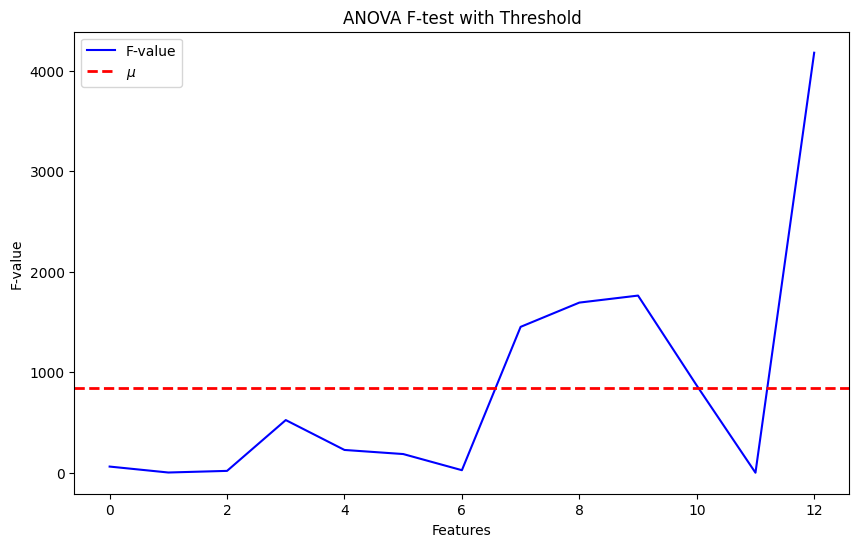

Eye_to_Nose  Eye_to_Lip  Eye_to_Chin  Eye_to_Eyebrow  age  age_binary
0       13.583078   36.090165    58.638724       12.589678   17           1
1       18.607794   38.147739    61.491869       12.369317   16           1
2       22.000000   45.011110    63.031738       10.547512   20           0
3       46.524187   78.000000   122.525508       25.578311   47           0
4        9.552487   36.667424    59.188259       14.713939   17           1
...           ...         ...          ...             ...  ...         ...
5607    21.523243   42.240384    66.017043        8.139410   16           1
5608     5.852350   33.305405    56.224994       15.402922   16           1
5609    17.066048   38.013156    59.052942       11.672618   16           1
5610    19.500000   41.500000    63.531488        7.017834   17           1
5611    53.500000  107.510465   136.532963       34.000000   80           0

[5612 rows x 6 columns]

      Eye_to_Nose  Eye_to_Lip  Eye_to_Chin  Eye_to_Eyebrow  age  age_binary
0       13.583078   36.090165    58.638724       12.589678   17           1
1       18.607794   38.147739    61.491869       12.369317   16           1
2       22.000000   45.011110    63.031738       10.547512   20           0
3       46.524187   78.000000   122.525508       25.578311   47           0
4        9.552487   36.667424    59.188259       14.713939   17           1
...           ...         ...          ...             ...  ...         ...
5607    21.523243   42.240384    66.017043        8.139410   16           1
5608     5.852350   33.305405    56.224994       15.402922   16           1
5609    17.066048   38.013156    59.052942       11.672618   16           1
5610    19.500000   41.500000    63.531488        7.017834   17           1
5611    53.500000  107.510465   136.532963       34.000000   80           0

[5612 rows x 6 columns]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt

# Separate features and labels
features = balanced_df.drop(columns=['filename', 'age_binary'])
labels = balanced_df['age_binary']

# Perform ANOVA F-test for each feature across age_binary groups
f_values, p_values = f_classif(features, labels)

# Create a DataFrame for ANOVA F-test results
results_df_anova = pd.DataFrame({
    'Feature': features.columns,
    'F-value': f_values,
    'p-value': p_values
})

# Calculate mean of F-values
mean_f = results_df_anova['F-value'].mean()

# Define threshold
threshold = mean_f

# Plot the F-values
plt.figure(figsize=(10, 6))
plt.plot(results_df_anova['F-value'].values, label='F-value', color='blue')

# Add threshold line
plt.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label='$\mu$')

# Add labels and legend
plt.xlabel('Features')
plt.ylabel('F-value')
plt.title('ANOVA F-test with Threshold')
plt.legend()

# Show the plot
plt.show()

# Filter features based on threshold
filtered_features = results_df_anova[results_df_anova['F-value'] >= threshold]['Feature']

# Create a new DataFrame with only the filtered features
filtered_feature_columns = filtered_features.tolist() + ['age_binary']
filtered_df = balanced_df[filtered_feature_columns]

# Display the filtered DataFrame
from IPython.display import display
display(filtered_df)

print(filtered_df)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Assuming lbp_df is already created and has the 'age_binary' column as the label
# Sample lbp_df for demonstration, replace with actual data
# lbp_df = pd.read_csv('your_data.csv')  # If your data is in a CSV file

# Separate features and labels
X = filtered_df.drop(columns=['age_binary', 'age'])  # Features
y = filtered_df['age_binary']  # Label

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Display the results
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Accuracy: 0.7497773820124666
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       579
           1       0.74      0.75      0.74       544

    accuracy                           0.75      1123
   macro avg       0.75      0.75      0.75      1123
weighted avg       0.75      0.75      0.75      1123

